Here Gauss-Seidel iterative scheme us applied to compare with Conjugate Gradient method:
$$
u_{i,j}^{n+1}=\frac{1}{4}[u_{i+1,j}^{n}+u_{i-1,j}^{n+1}+u_{i,j+1}^{n}+u_{i,j-1}^{n+1}-h^2f_{i,j}]
$$


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [19]:
# build the meshgrid with 20 points in each direction
dx = 1/20
dy = 1/20
x = np.arange(0, 1+dx, dx)
y = np.arange(0, 1+dy, dy)
X, Y = np.meshgrid(x, y)

In [20]:
mesh1 = np.zeros((len(x), len(y)))
# B.C.
mesh1[0] = 0
mesh1[-1] = 0
mesh1[:,0] = 0
mesh1[:,-1] = 0

def f(x, y):
    return -2 * np.pi**2 * np.sin(np.pi*x) * np.sin(np.pi*y)
fmesh = f(x[:,None], y[None, :])

def central_diff2(mesh, dx, dy):
    diff2_x = mesh[2:,1:-1] - 2*mesh[1:-1,1:-1] + mesh[:-2,1:-1]
    diff2_y = mesh[1:-1,2:] - 2*mesh[1:-1,1:-1] + mesh[1:-1,:-2]
    return np.linalg.norm(diff2_x / dx ** 2 + diff2_y / dy ** 2 - fmesh[1:-1, 1:-1])

def GaussSeidel(mesh, xl, yl, h, fmesh, max_iter=500):
    for _ in range(max_iter):
        for i in range(1, len(xl)-1):
            for j in range(1, len(yl)-1):
                mesh[i,j] = 0.25*(mesh[i-1,j]+mesh[i+1,j]+mesh[i,j-1]+mesh[i,j+1] - h**2*fmesh[i,j])
    return mesh
mesh2 = mesh1.copy()

In [21]:
max_iter = 500
mesh2 = GaussSeidel(mesh2, x, y, dx,fmesh, max_iter)

Text(0.5, 1.0, 'Gauss-Seidel contour plot')

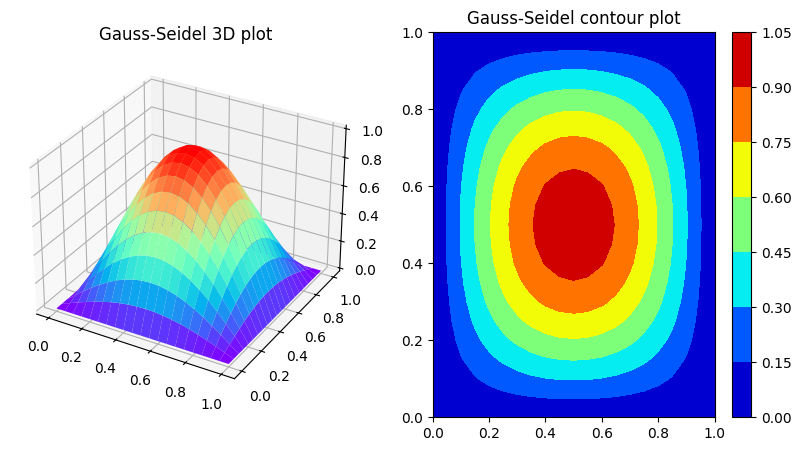

In [42]:
fig = plt.figure(figsize=(10,5))
# ax = Axes3D(fig,auto_add_to_figure=False)
ax = fig.add_subplot(1, 2, 1, projection='3d')
# ax.plot_surface(X, Y, mesh2, rstride = 1, cstride = 1, cmap = plt.get_cmap('rainbow'))
ax.plot_surface(X, Y, mesh2,  cmap = plt.get_cmap('rainbow'))
ax.set_title('Gauss-Seidel 3D plot')
ax2 = fig.add_subplot(1, 2, 2)
cp_u = ax2.contourf(X, Y, mesh2)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
ax2.set_title('Gauss-Seidel contour plot')

define A matrix, ready for Conjugate Method

In [23]:
v, v0 = len(x)*len(y), fmesh.shape[0]
h = dx
# define differentiate mat A where Au=b
def Amat(xl, yl, h, fmesh):
    # return A, b
    Ap = []
    b = []
    for i in range(len(xl)):
        for j in range(len(yl)):
            A = np.zeros((len(xl), len(yl)))
            # Add boundary
            if j == 0 or i == 0 or j == len(yl) - 1 or i == len(xl) - 1:
                A[i, j] = 1
                b.append(0)
            # Add grid
            else:
                A[i-1,j] += h**2
                A[i,j] += -2*h**2
                A[i+1,j] += h**2
                A[i,j-1] += h**2
                A[i,j] += -2*h**2
                A[i,j+1] += h**2
                b.append(fmesh[i, j])
            Ap.append(A.reshape(1, -1))
    Ap = np.array(Ap).squeeze()
    b = np.array(b).reshape(-1, 1)
    return Ap, b
Ap, b = Amat(x, y, dx, fmesh)

conjugate method main process

In [24]:
def conjugate_gradient(Ap, b, xr, max_iter=50):
    i, r = 0, Ap.T@b-Ap.T@Ap@xr
    p = r.copy()
    rTr = np.sum(r.conj()*r).real
    li = [rTr]
    while i < max_iter and rTr > 1e-10:
        Ar = Ap.T @ Ap @ p
        alpha = rTr / np.sum(p.conj()*Ar).real
        alpha = alpha
        xr = xr + alpha * p
        r = r - alpha * Ar
        rTrNew = np.sum(r.conj()*r).real
        li.append(rTrNew)
        beta = rTrNew / rTr
        beta = beta
        p = r + beta * p
        i += 1
        rTr = rTrNew
    return xr

conjugate method result

Text(0.5, 1.0, 'Conjugate Gradient contour plot')

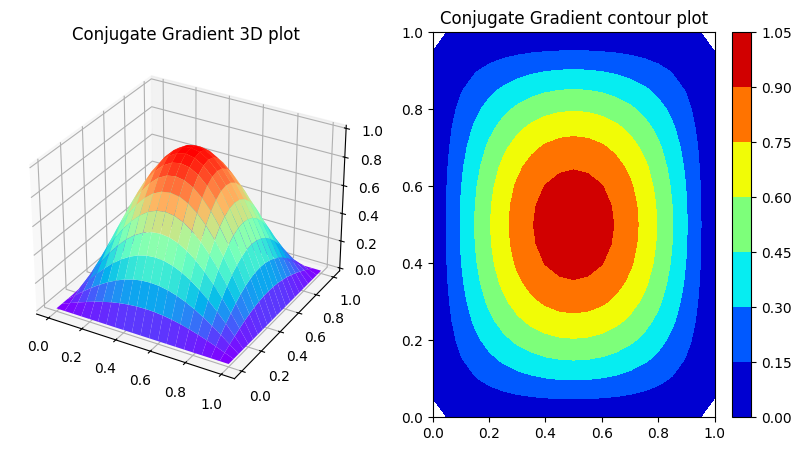

In [47]:
xh = np.zeros_like(fmesh.reshape(-1,1))
xh = conjugate_gradient(Ap, b, xh, max_iter)
xrplot = xh.reshape(v0, v0) / xh.max()
# plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, xrplot,  cmap = plt.get_cmap('rainbow'))
ax.set_title('Conjugate Gradient 3D plot')
ax2 = fig.add_subplot(122)
cp_u = ax2.contourf(X, Y, xrplot)
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
ax2.set_title('Conjugate Gradient contour plot')

In [26]:
# the loss between CG and GS, after normalization of CG result
np.linalg.norm(xrplot - mesh2)

0.020534593857197813

### Multi-grid method

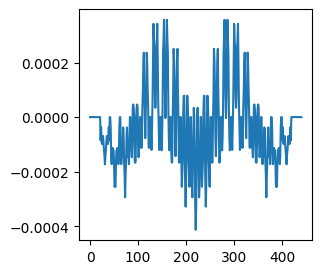

In [27]:
# See the result above is pre-smoothing process, now go on 2h
rh = b - Ap @ xh
plt.figure(figsize=(3,3))
plt.plot(rh)

(11, 11)


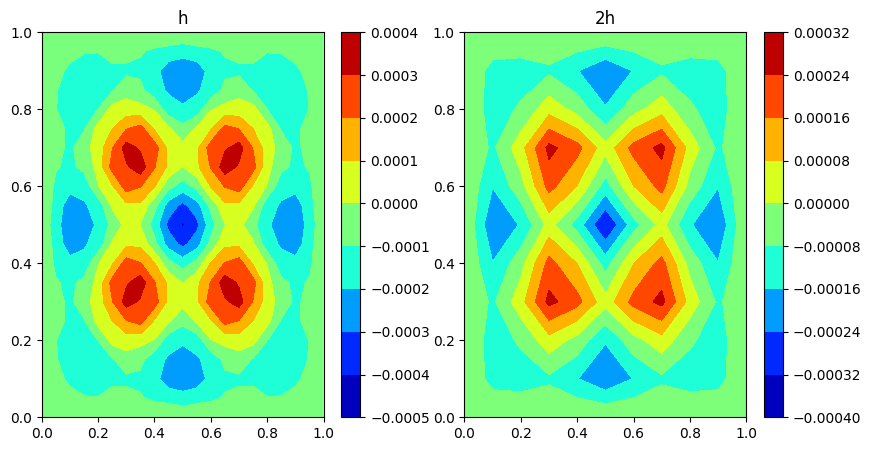

In [28]:
# restriction 2D
rmesh = rh.reshape((v0, v0))
kernel = np.array([
    [1/16, 1/8, 1/16],
    [1/8, 1/4, 1/8],
    [1/16, 1/8, 1/16],
])

clength = len([i for i in range(1, len(x)-1, 2)])+1
rcosmesh = np.zeros((clength, clength))
for i in range(2, len(x)-2, 2):
    for j in range(2, len(y)-2, 2):
        rcosmesh[i//2, j//2] = (kernel * rmesh[i-1:i+2, j-1:j+2]).sum()

# plot restriction result
xc = np.arange(0, 1+dx, dx*2)
yc = np.arange(0, 1+dx, dy*2)
Xc, Yc = np.meshgrid(xc, yc)
fig, axs = plt.subplots(1,2, figsize=(10, 5))
cp_u = axs[0].contourf(X, Y, rmesh)
axs[0].set_title("h")
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
cp_u2 = axs[1].contourf(Xc, Yc, rcosmesh)
axs[1].set_title("2h")
fig.colorbar(cp_u2) 
cp_u2.set_cmap('jet')
print(rcosmesh.shape)

In [29]:
# new A
# pad 0 to r2h
# rc = rcosmesh.shape[0]
# r2hpad = np.zeros((rc+2, rc+2))
# r2hpad[1:-1, 1:-1] = rcosmesh
r2hmesh = rh.reshape((v0, v0))
Ap2, r2 = Amat(xc, yc, dx*2, r2hmesh)
Ap2.shape, r2.shape

((121, 121), (121, 1))

In [30]:
# solve 2h residual problem
e = np.zeros_like(r2)
i, rp = 0, Ap2.T@r2-Ap2.T@Ap2@e
p = rp.copy()
rTr = np.sum(rp.conj()*rp).real
li2 = []
al = []
while i < 20 and rTr > 1e-10:
    Ar = Ap2.T @ Ap2 @ p
    alpha = rTr / np.sum(p.conj()*Ar).real
    al.append(rTr)
    alpha = alpha
    e = e + alpha * p
    rp = rp - alpha * Ar
    rTrNew = np.sum(rp.conj()*rp).real
    beta = rTrNew / rTr
    beta = beta
    p = rp + beta * p
    i += 1
    rTr = rTrNew

In [31]:
e2h = np.zeros_like(r2)
e2h = conjugate_gradient(Ap2, r2, e2h, max_iter)

In [32]:
# interp
eitem = e.flatten()
ehpad_l = len(x)+2
eh = np.zeros((ehpad_l, ehpad_l)) # pad mat
for i in range(len(xc)):
    for j in range(len(yc)):
        idx, idy = 2*i+1, 2*j+1
        eh[idx, idy] += eitem[i*len(yc)+j]
        eh[idx-1, idy] += eitem[i*len(yc)+j]/2
        eh[idx+1, idy] += eitem[i*len(yc)+j]/2
        eh[idx, idy-1] += eitem[i*len(yc)+j]/2
        eh[idx, idy+1] += eitem[i*len(yc)+j]/2
        eh[idx-1, idy-1] += eitem[i*len(yc)+j]/4
        eh[idx+1, idy-1] += eitem[i*len(yc)+j]/4
        eh[idx-1, idy+1] += eitem[i*len(yc)+j]/4
        eh[idx+1, idy+1] += eitem[i*len(yc)+j]/4
eh = eh[1:-1, 1:-1]
eh.shape

(21, 21)

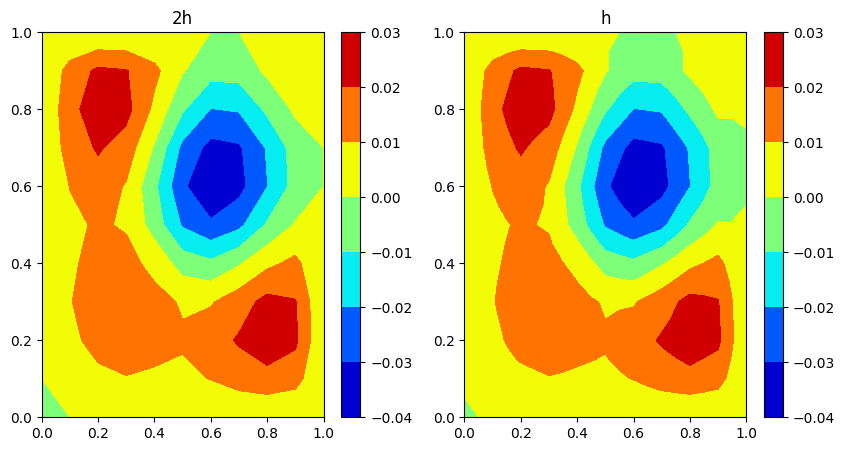

In [33]:
# plot of error
fig, axs = plt.subplots(1,2, figsize=(10, 5))
cp_u = axs[0].contourf(Xc, Yc, e2h.reshape(11, 11))
axs[0].set_title("2h")
fig.colorbar(cp_u) 
cp_u.set_cmap('jet')
cp_u2 = axs[1].contourf(X, Y, eh)
axs[1].set_title("h")
fig.colorbar(cp_u2) 
cp_u2.set_cmap('jet')

In [34]:
# compare the iterative results with pure GS
print("CG after %d iters: " % max_iter, np.linalg.norm(xrplot - mesh2))
xr2 = xh.reshape(v0,v0) + eh
xrplot2 = xr2.reshape(v0, v0) / xr2.max()
print("CG + multigrid:", np.linalg.norm(xrplot2 - mesh2))
# compare with pure CG, no multigrid
xh3 = np.zeros_like(fmesh.reshape(-1,1))
xh3 = conjugate_gradient(Ap, b, xh, max_iter*2)
xrplot3 = xh3.reshape(v0, v0) / xh3.max()
print("CG with %d iters: "%(max_iter*2), np.linalg.norm(xrplot3 - mesh2))

CG after 500 iters:  0.020534593857197813
CG + multigrid: 0.020533311882572448
CG with 1000 iters:  0.020534593857197813


Thus multigrid can make CG loss further decrease where CG itself cannot achieve by zooming iterations.

After a certain number of iterations, CG cannot achieve better performance. But with multigrid, implemented 2-Grid V-Cycle version here, better performance is achieved.

Here the standard value is pure Gauss-Seidel, which also has the feature of early convergence. When replaced by other standards or even DAS, whether this result would become better or worse is unknown.